## Tests of Repliseq Track

In [3]:
setwd("~/Upd-Germline-Genomics")

T-Test of Germline vs Somatic Timing (12 Regions)

In [2]:
source("_targets.R")

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
library(forcats)
library(GenomicRanges)

tar_load(chic.tile.diameter_1000_chr)
tar_load(matches("repli.timing_.*chr$"))
tar_load(chromosome_pericetromere_label)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:utils’:

    findMatches


The following objects are mask

In [5]:
obs <- tibble(
  region = as.character(seqnames(repli.timing_Germline_chr)) %>%
    paste0(
      rep("", length(repli.timing_Germline_chr)) %>%
        replace(
          to(findOverlaps(chromosome_pericetromere_label, repli.timing_Germline_chr)),
          "C"
        )
    ) %>%
      factor(
        c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y", "rDNA")
      ),
  x = mid(repli.timing_Germline_chr),
  GSC = qlogistanh(repli.timing_Germline_chr$score),
  CySC = qlogistanh(repli.timing_Somatic_chr$score),
  Kc167 = qlogistanh(repli.timing_Kc167_chr$score),
  S2 = qlogistanh(repli.timing_S2_chr$score),
) %>%
  subset(
    x %% 10000 == 5500 &
      !is.na(region) &
      (region != "rDNA" | x >= 37500)
  )
print(obs)

# A tibble: 13,759 × 6
   region     x   GSC  CySC   Kc167    S2
   <fct>  <int> <dbl> <dbl>   <dbl> <dbl>
 1 2L      5500  1.84 0.862  1.30   0.639
 2 2L     15500  1.75 1.18   1.95   0.311
 3 2L     25500  2.16 1.28   0.0573 0.573
 4 2L     35500  2.19 1.46   1.84   0.318
 5 2L     45500  2.05 0.981  0.301  0.618
 6 2L     55500  1.55 1.32  -1.13   1.05 
 7 2L     65500  1.58 1.39   3.29   0.462
 8 2L     75500  1.94 1.37   3.34   1.25 
 9 2L     85500  1.03 1.33   3.03   1.27 
10 2L     95500  2.10 2.34   3.10   0.640
# ℹ 13,749 more rows


In [23]:
obscen <- tibble(
  region = as.character(seqnames(repli.timing_Germline_chr)) %>%
    str_extract("[23]Cen") %>%
    paste0("Scaffold") %>%
    factor(c("2L", "2LC", "2CenScaffold", "2RC", "2R", "3L", "3LC", "3CenScaffold", "3RC", "3R")),
  x = mid(repli.timing_Germline_chr),
  GSC = qlogistanh(repli.timing_Germline_chr$score),
  CySC = qlogistanh(repli.timing_Somatic_chr$score),
  Kc167 = qlogistanh(repli.timing_Kc167_chr$score),
  S2 = qlogistanh(repli.timing_S2_chr$score),
) %>%
  subset(!is.na(region)) %>%
  print()

# A tibble: 8 × 6
  region           x   GSC   CySC Kc167     S2
  <fct>        <int> <dbl>  <dbl> <dbl>  <dbl>
1 2CenScaffold  9978 -2.16 -0.497 -2.73 -1.72 
2 2CenScaffold 22206 -1.72 -0.482 -2.64 -1.10 
3 3CenScaffold 38112 -1.30 -0.438 -2.36 -0.584
4 3CenScaffold  5992 -2.26 -0.416 -3.19 -2.57 
5 3CenScaffold 43683 -2.15 -0.520 -2.66 -0.711
6 3CenScaffold 18457 -2.26 -0.489 -3.07 -2.16 
7 3CenScaffold 11302 -1.92 -0.693 -2.00 -0.384
8 3CenScaffold 11619 -1.91 -0.458 -3.30 -2.77 


In [28]:
obs <- rbind(
  obs,
  obscen
) %>%
  mutate(
    region = factor(
      region,
      c("2L", "2LC", "2CenScaffold", "2RC", "2R", "3L", "3LC", "3CenScaffold", "3RC", "3R", "4", "X", "Y", "rDNA")
    )
  ) %>%
  arrange(region)

In [36]:
table(obs$region)


          2L          2LC 2CenScaffold          2RC           2R           3L 
        2219          132            2          565         1964         2315 
         3LC 3CenScaffold          3RC           3R            4            X 
         496            6          423         2785          135         2354 
           Y         rDNA 
         367            4 

In [37]:
obs %>%
  group_by(region) %>%
  summarise(across(!x, mean)) %>%
  write.table(row.names = FALSE, quote = FALSE, sep = "\t")

region	GSC	CySC	Kc167	S2
2L	0.240003773239944	-0.0251170605752422	0.134633855131178	0.111172790822162
2LC	-0.221179916212045	-1.29080187514596	-0.594244175968877	-0.906171349116361
2CenScaffold	-1.94432605402701	-0.489286174648313	-2.68607702669223	-1.40808291067734
2RC	-0.76377731470638	-1.06683856471266	-1.55509168659663	-1.09112602861674
2R	0.586178372723304	0.339229485942996	0.760754160234016	0.336881454202316
3L	0.344350158955915	0.207399879335181	0.512648229167886	0.181511685473339
3LC	-0.855531855471866	-1.32625693079921	-1.75411116883992	-0.980452144647513
3CenScaffold	-1.96664190651438	-0.502457082646003	-2.76394556945123	-1.530892189743
3RC	-1.42884791796216	-0.911969043051168	-3.56734129909786	-1.85824786846488
3R	0.425790707608911	1.67108614711728e-05	0.306255732245841	0.176124932005275
4	1.44057365612037	0.660502809392847	1.62789769169342	0.38098770408921
X	0.479817743442729	0.485223513007481	0.351674157858727	0.48122475800506
Y	-0.914869981409082	-0.563613795181887	-1.589

In [38]:
write.table(
  obs %>%
    group_by(region) %>%
    summarise(
      t.statistic = round(t.test(GSC, CySC)$statistic, 2),
      p.adjust = t.test(GSC, CySC)$p.value
    ) %>%
    mutate(p.adjust = p.adjust %>% p.adjust()),
  row.names = F,
  quote = F,
  sep = "\t"
)

region	t.statistic	p.adjust
2L	7.67	1.86279369316132e-13
2LC	9.95	1.95418070993955e-18
2CenScaffold	-6.6	0.190596585240699
2RC	4.92	5.09064017670156e-06
2R	7.45	8.88835497055045e-13
3L	4.1	0.00016578364337318
3LC	8.84	8.02520421554476e-17
3CenScaffold	-9.59	0.000278654387825226
3RC	-9.43	9.22423957696634e-19
3R	13.51	8.73537956468027e-40
4	10.21	1.02412571014942e-19
X	-0.18	0.85515051232606
Y	-5.85	5.93178702191535e-08
rDNA	38.15	3.12988638019876e-06


In [18]:
tail(rbind(obs, obscen))

region,x,GSC,CySC,Kc167,S2
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
3Cen,38112,-1.303070,-0.4383701,-2.355063,-0.5836734
3Cen,5992,-2.258204,-0.4159700,-3.192323,-2.5677326
3Cen,43683,-2.153540,-0.5204246,-2.664558,-0.7114268
3Cen,18457,-2.256011,-0.4889389,-3.071968,-2.1638090
3Cen,11302,-1.922689,-0.6929085,-2.000995,-0.3843600
3Cen,11619,-1.906337,-0.4581305,-3.298768,-2.7743513


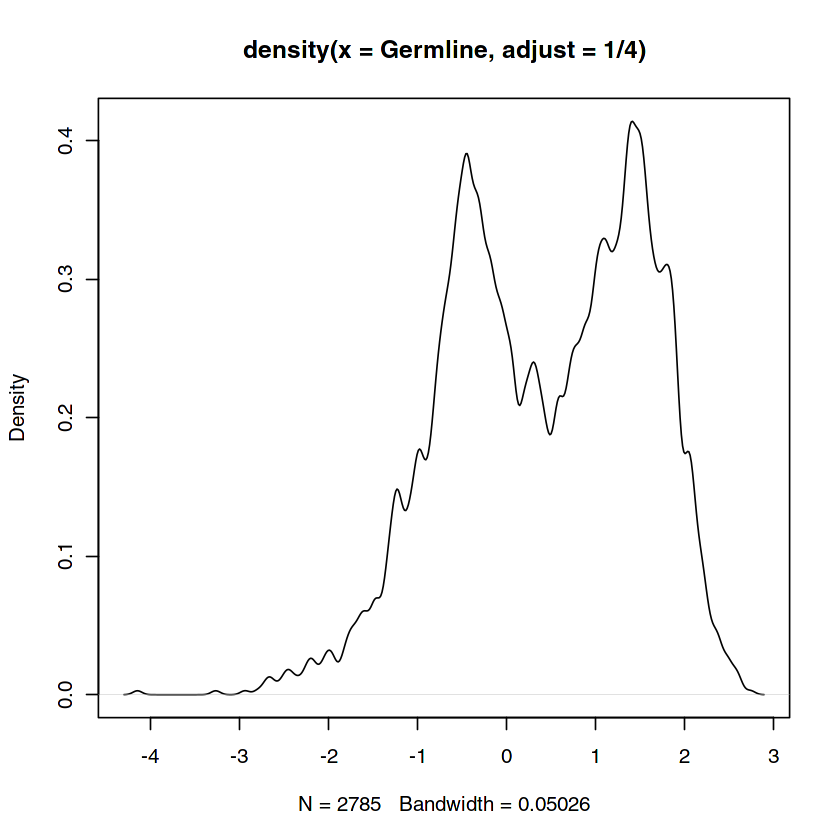

In [48]:
with(subset(obs, region == "3R"), plot(density(Germline, adjust=1/4)))

In [54]:
ks.test(
  with(subset(obs, region == "3R"), scale(Germline)),
  "pnorm"
)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  with(subset(obs, region == "3R"), scale(Germline))
D = 0.078059, p-value = 3.664e-15
alternative hypothesis: two-sided


In [53]:
ks.test(
  with(subset(obs, region == "3R"), scale(plogistanh(Germline))),
  "pnorm"
)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  with(subset(obs, region == "3R"), scale(plogistanh(Germline)))
D = 0.11628, p-value < 2.2e-16
alternative hypothesis: two-sided


In [40]:
write.csv(
  obs %>%
    group_by(region) %>%
    summarise(
      t.statistic = t.test(Germline, Somatic)$statistic,
      p.adjust = t.test(Germline, Somatic)$p.value,
    ) %>%
    mutate(p.adjust = p.adjust %>% p.adjust()),
  row.names = F,
  "reports/Repli-T-Test.csv"
)

ANOVA of Y Scaled & Testing the Posterior Distribution of the rDNA

1: Recapitulate Y-Scaled Z Score

In [2]:
source("_targets.R")

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
line_cmap <- c(chic_line_track_colors$germline, chic_line_track_colors$somatic, hcl(50, 102, 57), hcl(255, 102, 57))

library(forcats)

tar_load(chic.tile.diameter_1000_chr)
tar_load(matches("repli.timing_.*chr$"))
tar_load(chromosome_pericetromere_label)

In [4]:
chromosome_pericetromere_label

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:utils’:

    fin

GRanges object with 4 ranges and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]       2L 22192401-23513712      *
  [2]       2R         1-5651400      *
  [3]       3L 23154101-28110227      *
  [4]       3R         1-4229200      *
  -------
  seqinfo: 4 sequences from an unspecified genome; no seqlengths

In [5]:
enframe(chr.lengths/1000/1000)

name,value
<chr>,<dbl>
2L,23.513712
2R,25.286936
3L,28.110227
3R,32.079331
4,1.348131
X,23.542271
Y,3.667352


In [6]:
Y <- tibble(
  chr = names(chr.lengths),
  xmin = 2500,
  xmax = floor((chr.lengths - 2500) / 5000) * 5000,
  Germline = list(repli.timing_Germline_chr),
  Somatic = list(repli.timing_Somatic_chr),
  Kc167 = list(repli.timing_Kc167_chr),
  S2 = list(repli.timing_S2_chr),
) %>%
  group_by(chr, xmin, xmax) %>%
  reframe(
    x = seq(xmin, xmax, by = 5000),
    region = (
      as.character(chr) %>%
        paste0(
          replace(
            rep("", length(x)),
            chromosome_pericetromere_label %>%
              findOverlaps(
                GRanges(
                  chr,
                  IRanges(x, width=1),
                  seqlengths = seqlengths(repli.timing_Germline_chr)
                )
              ) %>%
              to(),
            "C"
          )
        ) %>%
      factor(
        c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y", "rDNA")
      )
    ),
    across(
      !matches("^(x|region)$"),
      list(
        LOESS = ~ (
          loess(
            y.track ~ x.track,
            tibble(
              x.track = .x[[1]][seqnames(.x[[1]]) == chr] %>% mid(),
              y.track = .x[[1]][seqnames(.x[[1]]) == chr]$score,
            ),
            span = 0.025
          ) %>%
          predict(tibble(x.track = x))
        )
      )
    )
  ) %>%
  subset(select = -c(xmin, xmax))

In [7]:
sum(is.na(Y$region))

[1] 0

In [8]:
rDNA <- mapply(
  \(gr, v_orig) (
    (
      gr[
        seqnames(gr) == "rDNA" &
          between(mid(gr), 37000, 77000)
      ]$score %>%
        mean()
    ) -
      mean(v_orig)
  ) /
    sd(v_orig),
  list(
    repli.timing_Germline_chr,
    repli.timing_Somatic_chr,
    repli.timing_Kc167_chr,
    repli.timing_S2_chr
  ),
  Y[
    c("Germline_LOESS", "Somatic_LOESS", "Kc167_LOESS", "S2_LOESS")
  ]
)
Y <- rbind(
  Y,
  tibble(
    chr = "rDNA",
    x = 57000,
    region = "rDNA",
    as_tibble(
      setNames(
        as.list(rDNA),
        colnames(Y)[4:7]
      )
    )
  )
)
tail(Y)

chr,x,region,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Y,3637500,Y,-0.2551883,-0.2256387,-0.7050496,-0.4268229
Y,3642500,Y,-0.2519863,-0.2102737,-0.6260181,-0.3906424
Y,3647500,Y,-0.2497008,-0.1900902,-0.5144327,-0.3388503
Y,3652500,Y,-0.2511598,-0.1643056,-0.3685433,-0.2707145
Y,3657500,Y,-0.2629694,-0.1327978,-0.1852171,-0.1852090
rDNA,57000,rDNA,1.2700077,-1.5555987,-1.9353602,-2.7976166


In [9]:
Y[Y$chr == "Y", 4:7] <- (
  Y[Y$chr == "Y", c(4, 5, 7)] %>%
    as.matrix() %>%
    `%*%`(
      matrix(
        c(
          1, 0, 0,
          0, 1, 0,
          NA, NA, NA,
          0, 0, 1
        ),
        nrow = 3,
        dimnames = list(
          NULL,
          colnames(Y)[4:7]
        )
      )
    )
)
tail(Y)

chr,x,region,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Y,3637500,Y,-0.2551883,-0.2256387,NA,-0.4268229
Y,3642500,Y,-0.2519863,-0.2102737,NA,-0.3906424
Y,3647500,Y,-0.2497008,-0.1900902,NA,-0.3388503
Y,3652500,Y,-0.2511598,-0.1643056,NA,-0.2707145
Y,3657500,Y,-0.2629694,-0.1327978,NA,-0.1852090
rDNA,57000,rDNA,1.2700077,-1.5555987,-1.93536,-2.7976166


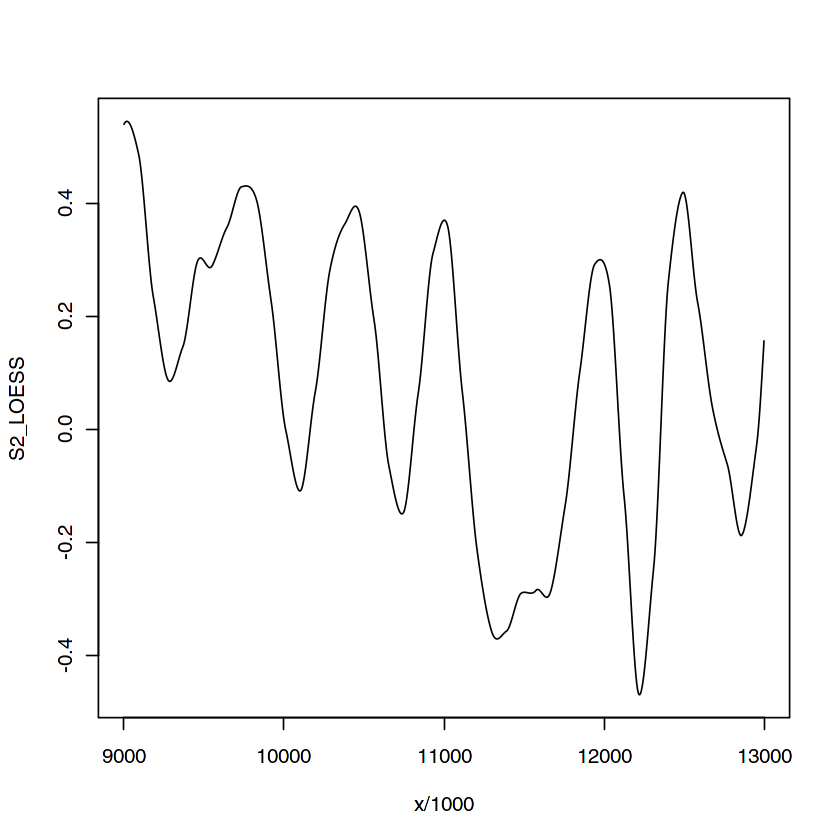

In [10]:
with(subset(Y, region == "2L" & between(x, 9*1000*1000, 13*1000*1000)), plot(x/1000, S2_LOESS, type='l'))


In [11]:
YS <- Y[
  c("Germline_LOESS", "Somatic_LOESS", "Kc167_LOESS", "S2_LOESS")
] %>%
  as.matrix() %>%
  scale() %>%
  t() %>%
  scale() %>%
  t()
YS[Y$chr == "Y", ] <- (
  YS[Y$chr == "Y", c(1, 2, 4)] %>%
    t() %>%
    scale() %>%
    t() %>%
    `%*%`(
      matrix(
        c(
          1, 0, 0,
          0, 1, 0,
          0, 0, 0,
          0, 0, 1
        ),
        nrow = 3,
        dimnames = list(
          NULL,
          colnames(Y)[4:7]
        )
      )
    )
)
tail(YS)

PCA <- prcomp(t(YS))
PCA$x %>%
  as.data.frame() %>%
  rownames_to_column("individual") %>%
  as_tibble() %>%
  print()


,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
"[27498,]",0.07483779,0.9604786,0.000000,-1.03531642
"[27499,]",-0.04177535,1.0202330,0.000000,-0.97845767
"[27500,]",-0.26002646,1.1043282,0.000000,-0.84430175
"[27501,]",-0.63157211,1.1529464,0.000000,-0.52137433
"[27502,]",-1.02107990,0.9774948,0.000000,0.04358505
"[27503,]",1.34525780,-0.1381486,-0.133108,-1.07400125


# A tibble: 4 × 5
  individual         PC1    PC2   PC3       PC4
  <chr>            <dbl>  <dbl> <dbl>     <dbl>
1 Germline_LOESS -146.     39.2 -25.7  4.76e-13
2 Somatic_LOESS    92.9   119.  -12.5 -1.38e-12
3 Kc167_LOESS       7.59  -50.0 114.   8.70e-13
4 S2_LOESS         45.8  -108.  -75.7  5.07e-14


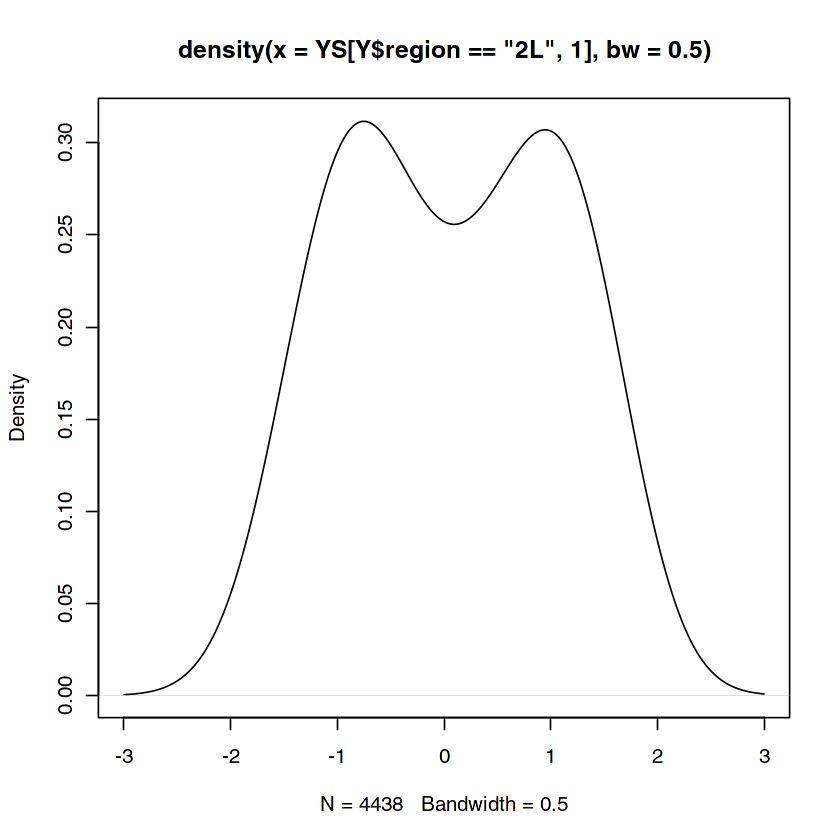

In [12]:
plot(density(YS[Y$region == "2L", 1], bw=0.5))

In [13]:
print(apply(YS[Y$region == "2L", ], 2, sd))

Germline_LOESS  Somatic_LOESS    Kc167_LOESS       S2_LOESS 
     0.9606863      0.9164612      0.7095344      0.8497575 


In [14]:
print(as_tibble(melt(YS[Y$region == "3L", ])))

# A tibble: 18,524 × 3
    Var1 Var2           value
   <int> <fct>          <dbl>
 1     1 Germline_LOESS 0.935
 2     2 Germline_LOESS 0.945
 3     3 Germline_LOESS 0.955
 4     4 Germline_LOESS 0.966
 5     5 Germline_LOESS 0.976
 6     6 Germline_LOESS 0.987
 7     7 Germline_LOESS 0.998
 8     8 Germline_LOESS 1.01 
 9     9 Germline_LOESS 1.02 
10    10 Germline_LOESS 1.03 
# ℹ 18,514 more rows


In [15]:
lm(
  value ~ Var2,
  melt(YS[Y$region == "3L", ]),
  subset = Var1 %% 3 == 1
) %>%
  anova()

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Var2,3,36.53697,12.1789891,16.35716,1.382548e-10
Residuals,6172,4595.46303,0.7445663,NA,NA


In [16]:
lm(
  value ~ Var2,
  melt(YS[Y$region == "3L", ]),
  subset = Var1 %% 20 == 10
) %>%
  anova()

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Var2,3,4.722028,1.5740094,2.103907,0.09816497
Residuals,924,691.277972,0.7481363,NA,NA


In [17]:
tar_load(repli.peaks_chr)

repli.peaks_chr$Dynamic_Static_Model %>% subset(seqnames == "rDNA")

GRanges object with 1 range and 2 metadata columns:
                       seqnames     ranges strand |   NegDiff   PosDiff
                          <Rle>  <IRanges>  <Rle> | <numeric> <numeric>
  rDNA.GermlineEarlier     rDNA 1001-76973      * | -0.440438   1.35072
  -------
  seqinfo: 1870 sequences from an unspecified genome; no seqlengths

In [18]:
tar_load(repli.bayes.factor_chr)

subset(repli.bayes.factor_chr, seqnames == "rDNA" & between(start, 37001, 77000)) %>%
  `$`("Dynamic_Static_Model") %>%
  summary()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
7.560e+02 1.150e+09 8.137e+10 8.107e+11 6.205e+11 1.349e+13 

In [19]:
write.table(
  tibble(
    region = levels(Y$region),
    p.adjust = p.adjust(
      c(
        sapply(
          region[1:11],
          \(region) lm(
            value ~ Var2,
            melt(YS[Y$region == region, ]),
            subset = Var1 %% 20 == 10
          ) %>%
            anova() %>%
            `[`(
              "Var2",
              "Pr(>F)"
            )
        ),
        1 / median(
          subset(repli.bayes.factor_chr, seqnames == "rDNA" & between(start, 37001, 77000)) %>%
            `$`("Dynamic_Static_Model")
        )
      )
    ),
    signif = structure(
      cut(
        p.adjust,
        c(-Inf, 1e-4, 1e-3, 1e-2, 5e-2, 1)
      ),
      levels = c("****", "***", "**", "*", ""),
      class = "factor"
    )
  ),
  quote=F,
  sep="\t",
  row.names=F
)

region	p.adjust	signif
2L	0.296626070989817	
2LC	7.64025099231965e-11	****
2RC	0.000985524185941884	***
2R	0.294494897069863	
3L	0.294494897069863	
3LC	0.260724336194536	
3RC	5.35786053113541e-28	****
3R	7.64025099231965e-11	****
4	8.86099917222918e-08	****
X	1.61707555913234e-45	****
Y	8.90622683773367e-13	****
rDNA	8.60267290110591e-11	****


Fisher's Exact Test of Individual Chromatin Regions In Terms of Replication Regime

In [1]:
library(dplyr)
library(targets)
library(withr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [12]:
tar_load(
  c(
    chromosome_pericetromere_label,
    repli.peaks_chr,
    chic.tile.diameter_1000_chr
  )
)

In [5]:
library(GenomicRanges)
sapply(repli.peaks_chr, \(gr) range(width(gr)))

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:utils’:

    findMatches


The following objects are mask

Germline_Somatic,Germline_Kc167,Germline_S2,Somatic_Kc167,Somatic_S2,Kc167_S2,Dynamic_Static_Model
20000,20000,20000,20000,20000,20000,20000
394000,676000,586000,444000,440000,1065000,2958000


In [6]:
table_levels <- c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y")
tables_kb <- repli.peaks_chr %>%
  head(6) %>%
  sapply(
    \(gr) cbind(
      gr %>%
        subset(grepl("Earlier", names(.))) %>%
        split(
          factor(
            paste0(
              as.factor(seqnames(.)),
              replace(
                rep("", length(.)),
                to(findOverlaps(chromosome_pericetromere_label, .)),
                "C"
              )
              ),
              table_levels
          )
        ) %>%
        sapply(\(gr) sum(width(gr))),
      gr %>%
        subset(grepl("Later", names(.))) %>%
        split(
          factor(
            paste0(
              as.factor(seqnames(.)),
              replace(
                rep("", length(.)),
                to(findOverlaps(chromosome_pericetromere_label, .)),
                "C"
              )
              ),
              table_levels
          )
        ) %>%
        sapply(\(gr) sum(width(gr)))
    ) %>%
      `/`(1000) %>%
      round(),
    simplify=FALSE
  ) %>%
  print()

$Germline_Somatic
    [,1] [,2]
2L  5036 3267
2LC  796    0
2RC 1447   39
2R  3124 2518
3L  4260 3806
3LC 1313    0
3RC  206   49
3R  6407 2692
4    258    0
X   2222 2008
Y     51  209

$Germline_Kc167
    [,1] [,2]
2L  6384 4540
2LC  384  159
2RC 1581  756
2R  4195 3991
3L  7058 4615
3LC 1768  829
3RC 1443  566
3R  9069 4197
4    240    0
X   8244 2313
Y   1148  974

$Germline_S2
    [,1] [,2]
2L  4264 4655
2LC  358  400
2RC  935  723
2R  4220 3502
3L  4477 4012
3LC  686  669
3RC  777  381
3R  6892 4889
4    596  105
X   1455 2855
Y    376  520

$Somatic_Kc167
    [,1] [,2]
2L  4188 3265
2LC    0  577
2RC    0 1739
2R  2426 3786
3L  4193 3365
3LC    0  871
3RC  551  276
3R  3333 4065
4    116  242
X   6224 1780
Y    395  230

$Somatic_S2
    [,1] [,2]
2L  3323 4555
2LC   41   64
2RC   83 1112
2R  2268 2879
3L  4263 4082
3LC    0  719
3RC  203   97
3R  3550 6267
4    239    0
X   2243 2382
Y    117  144

$Kc167_S2
    [,1] [,2]
2L  4743 6665
2LC  486   82
2RC 1567 1146
2R  5420 3745
3

In [7]:
table_levels <- c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y")
individual_unit_bp <- 50000
tables <- repli.peaks_chr %>%
  head(6) %>%
  sapply(
    \(gr) cbind(
      gr %>%
        subset(grepl("Earlier", names(.))) %>%
        split(
          factor(
            paste0(
              as.factor(seqnames(.)),
              replace(
                rep("", length(.)),
                to(findOverlaps(chromosome_pericetromere_label, .)),
                "C"
              )
              ),
              table_levels
          )
        ) %>%
        sapply(\(gr) sum(width(gr))),
      gr %>%
        subset(grepl("Later", names(.))) %>%
        split(
          factor(
            paste0(
              as.factor(seqnames(.)),
              replace(
                rep("", length(.)),
                to(findOverlaps(chromosome_pericetromere_label, .)),
                "C"
              )
              ),
              table_levels
          )
        ) %>%
        sapply(\(gr) sum(width(gr)))
    ) %>%
      `/`(individual_unit_bp) %>%
      ceiling(),
    simplify=FALSE
  ) %>%
  print()

$Germline_Somatic
    [,1] [,2]
2L   101   66
2LC   16    0
2RC   29    1
2R    63   51
3L    86   77
3LC   27    0
3RC    5    1
3R   129   54
4      6    0
X     45   41
Y      2    5

$Germline_Kc167
    [,1] [,2]
2L   128   91
2LC    8    4
2RC   32   16
2R    84   80
3L   142   93
3LC   36   17
3RC   29   12
3R   182   84
4      5    0
X    165   47
Y     23   20

$Germline_S2
    [,1] [,2]
2L    86   94
2LC    8    8
2RC   19   15
2R    85   71
3L    90   81
3LC   14   14
3RC   16    8
3R   138   98
4     12    3
X     30   58
Y      8   11

$Somatic_Kc167
    [,1] [,2]
2L    84   66
2LC    0   12
2RC    0   35
2R    49   76
3L    84   68
3LC    0   18
3RC   12    6
3R    67   82
4      3    5
X    125   36
Y      8    5

$Somatic_S2
    [,1] [,2]
2L    67   92
2LC    1    2
2RC    2   23
2R    46   58
3L    86   82
3LC    0   15
3RC    5    2
3R    71  126
4      5    0
X     45   48
Y      3    3

$Kc167_S2
    [,1] [,2]
2L    95  134
2LC   10    2
2RC   32   23
2R   109   75
3

In [16]:
chromosome_pericetromere_label

GRanges object with 4 ranges and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]       2L 22192401-23513712      *
  [2]       2R         1-5651400      *
  [3]       3L 23154101-28110227      *
  [4]       3R         1-4229200      *
  -------
  seqinfo: 4 sequences from an unspecified genome; no seqlengths

In [25]:
(
  table_level_seqlength_kb <- round(
    c(
      seqlengths(chic.tile.diameter_1000_chr)["2L"] - width(chromosome_pericetromere_label)[1],
      width(chromosome_pericetromere_label)[1],
      width(chromosome_pericetromere_label)[2],
      seqlengths(chic.tile.diameter_1000_chr)["2R"] - width(chromosome_pericetromere_label)[2],
      seqlengths(chic.tile.diameter_1000_chr)["3L"] - width(chromosome_pericetromere_label)[3],
      width(chromosome_pericetromere_label)[3],
      width(chromosome_pericetromere_label)[4],
      seqlengths(chic.tile.diameter_1000_chr)["3R"] - width(chromosome_pericetromere_label)[4],
      seqlengths(chic.tile.diameter_1000_chr)["4"],
      seqlengths(chic.tile.diameter_1000_chr)["X"],
      seqlengths(chic.tile.diameter_1000_chr)["Y"]
    ) /
      1000
  ) %>%
    setNames(table_levels)
)

2L   2LC   2RC    2R    3L   3LC   3RC    3R     4     X     Y 
22192  1321  5651 19636 23154  4956  4229 27850  1348 23542  3667

In [8]:
pval <- with_seed(
  0,
  sapply(
    tables,
    \(tb) fisher.test(tb, simulate=T, B=5e5)$p.value
  ) %>%
    p.adjust()
)
pval

Germline_Somatic   Germline_Kc167      Germline_S2    Somatic_Kc167 
    1.199998e-05     1.999996e-05     5.291989e-03     1.199998e-05 
      Somatic_S2         Kc167_S2 
    1.199998e-05     1.199998e-05

In [9]:
naive_analysis <- tibble(
  rowname = names(tables) %>% rep(each = nrow(tables[[1]])),
  counts = tables %>%
    do.call(rbind, .),
  residuals = sapply(tables, \(tb) chisq.test(tb)$residuals, simplify=FALSE) %>%
    do.call(rbind, .)
) %>%
  print()

Warning message in chisq.test(tb):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(tb):
“Chi-squared approximation may be incorrect”


Warning message in chisq.test(tb):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(tb):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(tb):
“Chi-squared approximation may be incorrect”


# A tibble: 66 × 3
   rowname          counts[,1]  [,2] residuals[,1]   [,2]
   <chr>                 <dbl> <dbl>         <dbl>  <dbl>
 1 Germline_Somatic        101    66        -0.447  0.586
 2 Germline_Somatic         16     0         1.85  -2.43 
 3 Germline_Somatic         29     1         2.30  -3.02 
 4 Germline_Somatic         63    51        -1.07   1.40 
 5 Germline_Somatic         86    77        -1.68   2.20 
 6 Germline_Somatic         27     0         2.40  -3.15 
 7 Germline_Somatic          5     1         0.619 -0.812
 8 Germline_Somatic        129    54         1.24  -1.62 
 9 Germline_Somatic          6     0         1.13  -1.49 
10 Germline_Somatic         45    41        -1.27   1.67 
# ℹ 56 more rows


In [10]:
exact_post_hoc_analysis <- naive_analysis %>%
  group_by(rowname = factor(rowname, unique(rowname))) %>%
  reframe(
    region = table_levels,
    residuals,
    p.adjust = sapply(
      seq_along(table_levels),
      \(i) fisher.test(
        rbind(
          counts[i,, drop=F],
          colSums(counts[-i,, drop=F])
        )
      )$p.value
    )
  ) %>%
  mutate(
    p.adjust = p.adjust %>% p.adjust(),
    signif = cbind(
      p.adjust %>%
        replace(residuals[, 2] >= residuals[, 1], 1),
      p.adjust %>%
        replace(residuals[, 2] <= residuals[, 1], 1)
    ) %>%
      cut(c(-Inf, 1e-4, 1e-3, 1e-2, 5e-2, Inf)) %>%
      structure(
        levels = c("****", "***", "**", "*", ""),
        class = "factor"
      ) %>%
      as.character() %>%
      matrix(ncol = 2),
    .keep = "unused"
  ) %>%
  print()

# A tibble: 66 × 4
   rowname          region p.adjust signif[,1] [,2] 
   <fct>            <chr>     <dbl> <chr>      <chr>
 1 Germline_Somatic 2L     1        ""         ""   
 2 Germline_Somatic 2LC    0.0467   "*"        ""   
 3 Germline_Somatic 2RC    0.00129  "**"       ""   
 4 Germline_Somatic 2R     1        ""         ""   
 5 Germline_Somatic 3L     0.131    ""         ""   
 6 Germline_Somatic 3LC    0.000304 "***"      ""   
 7 Germline_Somatic 3RC    1        ""         ""   
 8 Germline_Somatic 3R     0.999    ""         ""   
 9 Germline_Somatic 4      1        ""         ""   
10 Germline_Somatic X      1        ""         ""   
# ℹ 56 more rows


In [28]:
signif_p <- function(p) {
  structure(
    cut(
      p,
      c(-Inf, 1e-4, 1e-3, 1e-2, 5e-2, 1)
    ),
    levels = c("****", "***", "**", "*", ""),
    class = "factor"
  )
}
write.table(
  cbind(
    region = exact_post_hoc_analysis$region[1:11],
    GE = tables_kb[[1]][, 1],
    SE = tables_kb[[1]][, 2],
    PGE = round(100 * tables_kb[[1]][, 1] / table_level_seqlength_kb, 2),
    PSE = round(100 * tables_kb[[1]][, 2] / table_level_seqlength_kb, 2),
    S1 = subset(exact_post_hoc_analysis, rowname == "Germline_Somatic")$signif[, 1],
    S2 = subset(exact_post_hoc_analysis, rowname == "Germline_Somatic")$signif[, 2],
    GE.1 = tables_kb[[2]][, 1],
    KE = tables_kb[[2]][, 2],
    PGE.1 = round(100 * tables_kb[[2]][, 1] / table_level_seqlength_kb, 2),
    PKE = round(100 * tables_kb[[2]][, 2] / table_level_seqlength_kb, 2),
    S3 = subset(exact_post_hoc_analysis, rowname == "Germline_Kc167")$signif[, 1],
    S4 = subset(exact_post_hoc_analysis, rowname == "Germline_Kc167")$signif[, 2],
    GE.2 = tables_kb[[3]][, 1],
    NE = tables_kb[[3]][, 2],
    PGE.2 = round(100 * tables_kb[[3]][, 1] / table_level_seqlength_kb, 2),
    PNE = round(100 * tables_kb[[3]][, 2] / table_level_seqlength_kb, 2),
    S5 = subset(exact_post_hoc_analysis, rowname == "Germline_S2")$signif[, 1],
    S6 = subset(exact_post_hoc_analysis, rowname == "Germline_S2")$signif[, 2],
    SE.1 = tables_kb[[4]][, 1],
    KE.1 = tables_kb[[4]][, 2],
    PSE.1 = round(100 * tables_kb[[4]][, 1] / table_level_seqlength_kb, 2),
    PKE.1 = round(100 * tables_kb[[4]][, 2] / table_level_seqlength_kb, 2),
    S7 = subset(exact_post_hoc_analysis, rowname == "Somatic_Kc167")$signif[, 1],
    S8 = subset(exact_post_hoc_analysis, rowname == "Somatic_Kc167")$signif[, 2],
    SE.2 = tables_kb[[5]][, 1],
    NE.1 = tables_kb[[5]][, 2],
    PSE.2 = round(100 * tables_kb[[5]][, 1] / table_level_seqlength_kb, 2),
    PNE.1 = round(100 * tables_kb[[5]][, 2] / table_level_seqlength_kb, 2),
    S9 = subset(exact_post_hoc_analysis, rowname == "Somatic_S2")$signif[, 1],
    S10 = subset(exact_post_hoc_analysis, rowname == "Somatic_S2")$signif[, 2],
    KE.2 = tables_kb[[6]][, 1],
    NE.2 = tables_kb[[6]][, 2],
    PKE.2 = round(100 * tables_kb[[6]][, 1] / table_level_seqlength_kb, 2),
    PNE.2 = round(100 * tables_kb[[6]][, 2] / table_level_seqlength_kb, 2),
    S11 = subset(exact_post_hoc_analysis, rowname == "Kc167_S2")$signif[, 1],
    S12 = subset(exact_post_hoc_analysis, rowname == "Kc167_S2")$signif[, 2]
  ),
  row.names = F,
  col.names = F,
  quote = F,
  sep = "\t"
)

2L	5036	3267	22.69	14.72			6384	4540	28.77	20.46			4264	4655	19.21	20.98			4188	3265	18.87	14.71			3323	4555	14.97	20.53			4743	6665	21.37	30.03		
2LC	796	0	60.26	0	*		384	159	29.07	12.04			358	400	27.1	30.28			0	577	0	43.68		**	41	64	3.1	4.84			486	82	36.79	6.21		
2RC	1447	39	25.61	0.69	**		1581	756	27.98	13.38			935	723	16.55	12.79			0	1739	0	30.77		****	83	1112	1.47	19.68		*	1567	1146	27.73	20.28		
2R	3124	2518	15.91	12.82			4195	3991	21.36	20.32		*	4220	3502	21.49	17.83			2426	3786	12.35	19.28			2268	2879	11.55	14.66			5420	3745	27.6	19.07	***	
3L	4260	3806	18.4	16.44			7058	4615	30.48	19.93			4477	4012	19.34	17.33			4193	3365	18.11	14.53			4263	4082	18.41	17.63			6221	5698	26.87	24.61		
3LC	1313	0	26.49	0	***		1768	829	35.67	16.73			686	669	13.84	13.5			0	871	0	17.57		***	0	719	0	14.51		*	213	1605	4.3	32.38		**
3RC	206	49	4.87	1.16			1443	566	34.12	13.38			777	381	18.37	9.01			551	276	13.03	6.53			203	97	4.8	2.29			114	189	2.7	4.47		
3R	6407	2692	23.01	9.67			9069	4197	32.56	15.07